Hello! Let's take a swing at time series forecasting. The goal is to use the hydrometer and thermometer data collected from my basement to predict a week in advance. We can check out some different methods and try to tune one well enough to make an educated prediction.

Why bother making a model like this? We COULD just smooth a rolling average and use a line of regression to predict when the basement temp becomes unacceptable, but then we loose a lot of character from the data. The goal of this project is to help protect my wine. The average temperature in a week may never go beyond room temperature, but we need to know how often and how long these warm periods are.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm

df = pd.read_csv('Govee_12hr.csv')
df.columns = ['time','temp','humid']

In [2]:
df.describe()

,temp,humid
count,133.000000,133.000000
mean,62.943759,72.051128
std,3.360886,6.978914
min,52.880000,53.900000
25%,60.260000,67.400000
50%,63.680000,72.900000
75%,65.300000,77.500000
max,71.240000,85.400000


Let's discuss the data. Thankfully, Govee exports perfectly clean information. We have over 66 days of 12-hour temperature and humidity readings.

Note: I originally tried this with 15 minute intervals, but hyperparameter determination and fitting got more confusing. In parameter diagnostics, I was getting AIC (the standard prediction error) of tens of thousands - not good. I have a lot to learn about time series, but it's interesting to see how too much data can overwhelm processes. From what I can tell, increasing the interval size upon export returns the interval average, not a downsampling of 15min readings.

Text(0, 0.5, 'Temperature [°F] | Humidity %')

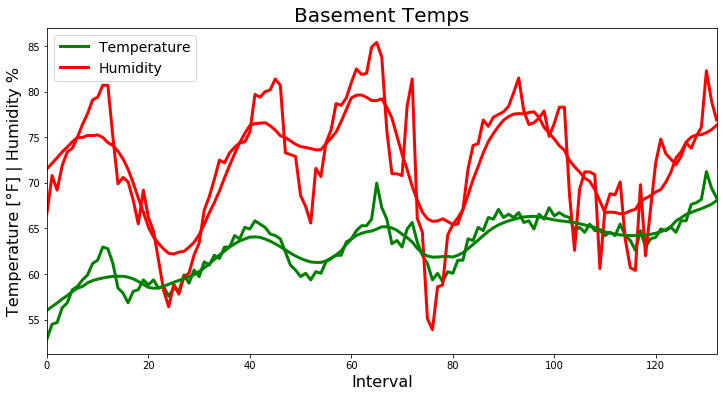

In [3]:
df['temp_SMA_1wk'] = df.temp.rolling(14, min_periods=1, center=True).mean()
df['humid_SMA_1wk'] = df.humid.rolling(14, min_periods=1, center=True).mean()


colors = ['green', 'red','green','red']

df.plot(color=colors, linewidth=3, figsize=(12,6))


plt.legend(labels =['Temperature', 'Humidity'], fontsize=14)

plt.title('Basement Temps', fontsize=20)
plt.xlabel('Interval', fontsize=16)
plt.ylabel('Temperature [°F] | Humidity %', fontsize=16)

Above, we inspect the behavior of the rolling average. This is helpful in determining the methods and the parameters. With humidity up top, we see periodic behavior - this trait is $seasonality$. With temperature, not only do we see seasonality, we see clear, gradual increase - this variable has both $seasonality$ and $trend$. Thus, I chose to implement a SARIMAX model (Seasonal Auto-Regressive Integrated Moving Average with Exogenous factors). Let's touch on each trait.(\*)

Seasonal: We measure and expect cyclic behavior.

Auto-Regressive: Although today's weather doesn't determine tomorrow's, we can safely say that the relationship between the two isn't random. So we estimate an autoregressive model: 

$y_t(r) = \omega + \alpha_1y_{t-1} + \dots + \alpha_ry_{t-r}$

for $r$ degrees of $lag$ where $\omega$ is a semi-random noise function. Our parameters $\{\alpha_i\}$ are determined by many hyperparameters determined in the training process.

Moving Average: This is the measurement for trend.

Exogeneity: This trait operates on the assumption that the model is not insulated, that we accept a little more noise freedom and don't expect to adhere very tightly to the lag model. This naïve assumption gives us some room not to overfit.

Now we train. Out of regard to integrity, all nonoriginal ideas are denoted with (\*) and (\*\*) and so on with sources at the end.

There is a lot of deep theory with time series and autoregression. Without getting into the weeds, let's instead do a hyperparameter search. Doing this makes our predictions vulnerable to overfitting and bias, but I'm just protecting my wine, not landing on the moon.

In [4]:
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
peaks, _ = find_peaks(df['temp_SMA_1wk'].to_numpy())
print("Approx season durations: ",np.diff(peaks))

Approx season durations:  [27 25 13 17]


We will pick the highest-performing set of parameters. The final seasonal parameter, the estimated length of a period, we fix at 21 because I knew I could take the average distance among peaks to estimate the cycle - but I needed some tools from scipy signal processing above.

Below is the iterative process we'll use to pick model parameters.(\*\*)

In [5]:
p = q = d = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],21) for x in list(itertools.product(p,d,q))]

In [6]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            model = sm.tsa.statespace.SARIMAX(df['temp'],
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_invertibility=False,
                                              enforce_stationarity=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            

ARIMA(0, 0, 0)x(0, 0, 0, 21) - AIC:1470.8204059242003
ARIMA(0, 0, 0)x(0, 0, 1, 21) - AIC:1144.2731443260247
ARIMA(0, 0, 0)x(0, 1, 0, 21) - AIC:589.9984062725109
ARIMA(0, 0, 0)x(0, 1, 1, 21) - AIC:469.155673277302
ARIMA(0, 0, 0)x(1, 0, 0, 21) - AIC:584.4651060150159
ARIMA(0, 0, 0)x(1, 0, 1, 21) - AIC:550.1740131272719
ARIMA(0, 0, 0)x(1, 1, 0, 21) - AIC:478.55696854959183
ARIMA(0, 0, 0)x(1, 1, 1, 21) - AIC:467.32296583349057
ARIMA(0, 0, 1)x(0, 0, 0, 21) - AIC:1293.5654647577076
ARIMA(0, 0, 1)x(0, 0, 1, 21) - AIC:1005.9022123827123
ARIMA(0, 0, 1)x(0, 1, 0, 21) - AIC:529.5275646485331
ARIMA(0, 0, 1)x(0, 1, 1, 21) - AIC:408.8272091931168
ARIMA(0, 0, 1)x(1, 0, 0, 21) - AIC:533.0440837308807


/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 21) - AIC:547.0182327721185
ARIMA(0, 0, 1)x(1, 1, 0, 21) - AIC:427.6525507624959
ARIMA(0, 0, 1)x(1, 1, 1, 21) - AIC:409.0063838688752
ARIMA(0, 1, 0)x(0, 0, 0, 21) - AIC:405.58549214038646
ARIMA(0, 1, 0)x(0, 0, 1, 21) - AIC:339.52838823207566
ARIMA(0, 1, 0)x(0, 1, 0, 21) - AIC:441.9590836615281
ARIMA(0, 1, 0)x(0, 1, 1, 21) - AIC:305.2561024526494
ARIMA(0, 1, 0)x(1, 0, 0, 21) - AIC:337.3590537682653
ARIMA(0, 1, 0)x(1, 0, 1, 21) - AIC:336.5071280494339
ARIMA(0, 1, 0)x(1, 1, 0, 21) - AIC:311.66326235363846
ARIMA(0, 1, 0)x(1, 1, 1, 21) - AIC:298.0381337400041
ARIMA(0, 1, 1)x(0, 0, 0, 21) - AIC:404.2616668351446
ARIMA(0, 1, 1)x(0, 0, 1, 21) - AIC:337.9309143447458
ARIMA(0, 1, 1)x(0, 1, 0, 21) - AIC:433.5624476004753
ARIMA(0, 1, 1)x(0, 1, 1, 21) - AIC:305.41928281199256
ARIMA(0, 1, 1)x(1, 0, 0, 21) - AIC:339.1176869636067
ARIMA(0, 1, 1)x(1, 0, 1, 21) - AIC:336.43350432887485
ARIMA(0, 1, 1)x(1, 1, 0, 21) - AIC:312.9539627890219
ARIMA(0, 1, 1)x(1, 1, 1, 21) - AIC:296.87

/Users/macdelay/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 21) - AIC:349.1296528758549
ARIMA(1, 0, 0)x(0, 1, 0, 21) - AIC:439.89001308386344


KeyboardInterrupt: 

If I were a statistician of any worth, I would know what the descriptions below are telling me. The diagnostics function after it is a little more intuitive.

Another fun note: I've gotten better AIC scores from noodling around with more arbitrary parameters. This is another learning example of how a scientist shouldnt just run with whatever appears to perform best on paper. Sure, it may perform better, but the model becomes even more abstracted and less intelligible.

In [7]:
model = sm.tsa.statespace.SARIMAX(df['temp'],
                                  order=(1,1,1),
                                  seasonal_order=(0,1,1,21),
                                  enforce_invertibility=False,
                                  enforce_stationarity=False)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 21)   Log Likelihood                -136.505
Date:                            Tue, 11 May 2021   AIC                            281.010
Time:                                    08:46:11   BIC                            290.919
Sample:                                         0   HQIC                           285.002
                                            - 133                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9975      0.005   -184.261      0.000      -1.008      -0.987
ma.L1          1.0000    217.865      0.005      0.996    -426.008     428.008
ma.S.L21      -1.0001   1269.972     -0.001      0.999   -2490.099    2488.098
sigma2         0.9885   1285.903      0.001      0.999   -2519.336    2521.313
===================================================================================
Ljung-Box (Q):                       29.10   Jarque-Bera (JB):                12.42
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.39
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC sumarizes a lot of the important qualities of the model for us, but one could look closely themselves. Most importantly, we can see the range and distribution of error at each retrospectively predicted timestamp.

In [8]:
results.aic

281.0099003299724

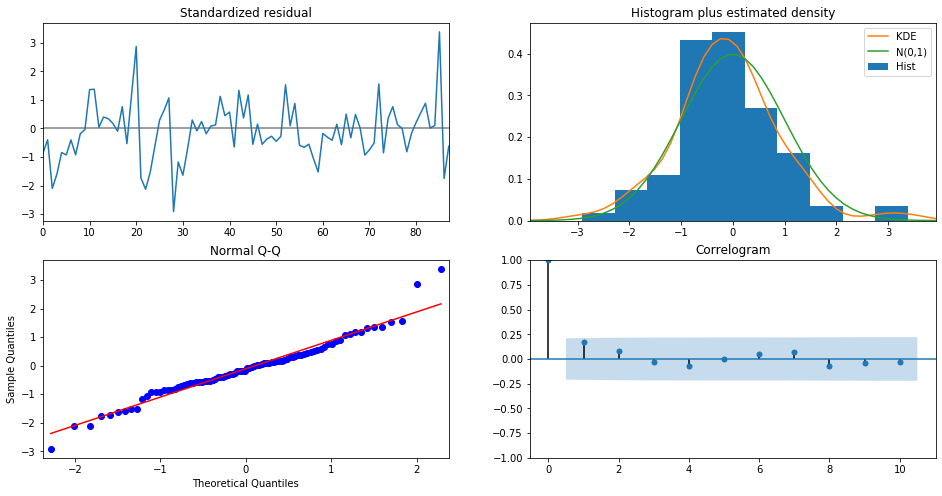

In [9]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

Let's take a look at the actual restrospective predictions based on our modelled function.

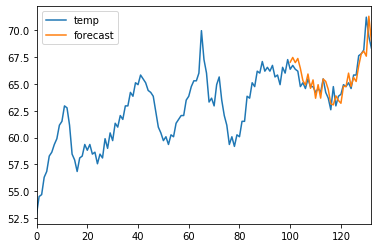

In [53]:
df['forecast']=results.predict(start=100,end=132,dynamic=False)
df[['temp','forecast']].plot()

In [64]:
forecast = pd.DataFrame(results.predict(start=133, end= 200, dynamic = True))

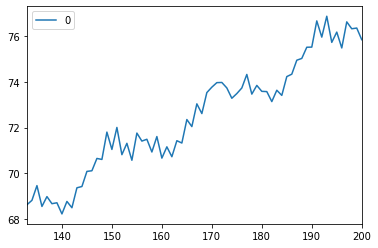

In [65]:
forecast.plot()

We see above that after the periods ~170, the temperature escapes 72 degrees. At this point, there is no sense in keeping the wine in the basement over a typical room in the house as we don't want the wine to 'cook'. The statistical recommendation is to consider moving the wine in about 19 days (or at least monitor the temperature cautiously around then).

I chose to train on all of the available data because I don't have a very big window to begin with. I'll take a preliminary swing at measuring true error. Below, I'll just plot the absolute most recent data (~5 days) against the prediction.

In [66]:
tester = pd.read_csv('Govee_Test.csv')
tester.tail()

,Timestamp for sample frequency every 12 Hrs min,Temperature_Fahrenheit,Relative_Humidity
19,2021-05-08 20:46:00,66.02,75.6
20,2021-05-09 08:46:00,66.20,76.7
21,2021-05-09 20:46:00,68.36,77.8
22,2021-05-10 08:46:00,67.64,79.6
23,2021-05-10 20:46:00,68.90,80.9


In [67]:
predFrame = pd.DataFrame(results.predict(start=133, end= 156, dynamic = True))

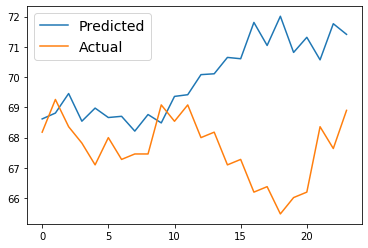

In [68]:
plt.plot(range(0,24),predFrame)
plt.plot(range(0,24),tester['Temperature_Fahrenheit'])
plt.legend(labels =['Predicted', 'Actual'], fontsize=14)

Unfortunately, it appears that a horozontal line would have performed better. However, my feelings aren't hurt because it is the weather after all, and I only have 10 tester points. I supposed I could go deeper through multivariate forecasting, but this was difficult and accurate enough for me - I learned a lot.

(\*)"Lecture 13 Time Series Analysis". Jordan Kern. North Carolina State University [?]. https://www.youtube.com/watch?v=Prpu_U5tKkE

(\*\*)"An End-to-End Project on Time Series Analysis and Forecasting with Python". Susan Li. https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

Actually, yeah. Let's try linear regression.

In [69]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(np.reshape(np.array(range(0,133)),(133,1)), df.temp)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

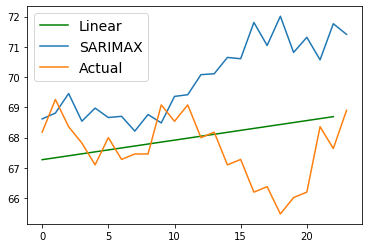

In [70]:
x=np.reshape(np.array(range(133,156)),(23,1))
plt.plot(lin_reg.predict(x), color='green')
plt.plot(range(0,24),predFrame)
plt.plot(range(0,24),tester['Temperature_Fahrenheit'])
plt.legend(labels =['Linear', 'SARIMAX','Actual'], fontsize=14)

Ouch. So it did better. This is a great learning oportunity. Not all complicated questions have complicated solutions. According to our linear model, we would move the wine when we hit 72 degrees, ~37 days.